#### TODO
* Use session # as a feature
* Compute log(loudleft) and log(loudright)



#### Data Exploration
I used [this page](https://jmetzen.github.io/2015-01-29/ml_advice.html) to guide the exploration.

There are 3 classes, labels are as follows:

Label | Description
--|--
S | Student
TA | TA
SI | Silent


The ground truth instances are not evenly distributed. Overall, we have ~4,000 TA, ~3000 Silent, and ~1500 student instances. Across all sessions students had fewest instances. In 2 out of 3 sessions, TA spoke longer than students. The duration of sessions differ:

Session | # instances
--|--
9 | 2822
10 | 3514
11 | 2808


Our baseline uses a heuristic algorithm. Overall the heuristic algorithm does poorly in determining student state (13% precision). In most cases students are classified as silent (971/1475 instances are silent). Determining TA state is also low (67% accuracy), again much confusion with silent state (1342/4331 are silent). Seems like we are overfitting to silent.




#### Load Data

In [127]:
# Load the data
import pandas as pd
xls = pd.ExcelFile('data/allData.xlsx')
train = xls.parse('allTrain-noFormulas')

In [ ]:
# Remove unused columns
import kinecture
kinecture.remove_columns(train, ['id', 'order', 'SISP', 'SNS', 'audTime'])

In [138]:
import math
train['logLoudnessLeft'] = train['loudnessLeft'].map(lambda x: math.log(x + 1e-5))
train['logLoudnessRight'] = train['loudnessRight'].map(lambda x: math.log(x + 1e-5))
train['silenceLeftRight'] = train['silenceLeft'] & train['silenceRight']

In [142]:
for i, c in enumerate(train.columns):
    print("{}:{}".format(i, c))

0:session
1:timestampUNIX
2:heuristic
3:duration
4:angleLeft
5:angleRight
6:confidenceLeft
7:confidenceRight
8:loudnessLeft
9:loudnessRight
10:silenceLeft
11:silenceRight
12:speakerX
13:speakerY
14:confLangle
15:confRangle
16:pLeft
17:pRight
18:qLeft
19:qRight
20:loudnessAve
21:loudnessDiff
22:pLeftZ
23:pRightZ
24:qLeftZ
25:qRightZ
26:logLoud
27:logLoudDiff
28:logLoudZ
29:logLoudDiffZ
30:Truth
31:logLoudnessLeft
32:logLoudnessRight
33:silenceLeftRight


#### Visualization

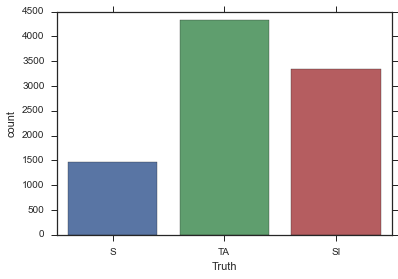

In [131]:
# How many ground truth labels of eatch type
# see http://stanford.edu/~mwaskom/software/seaborn/tutorial/categorical.html?highlight=categorical
sns.countplot(x="Truth", data=train)

In [134]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

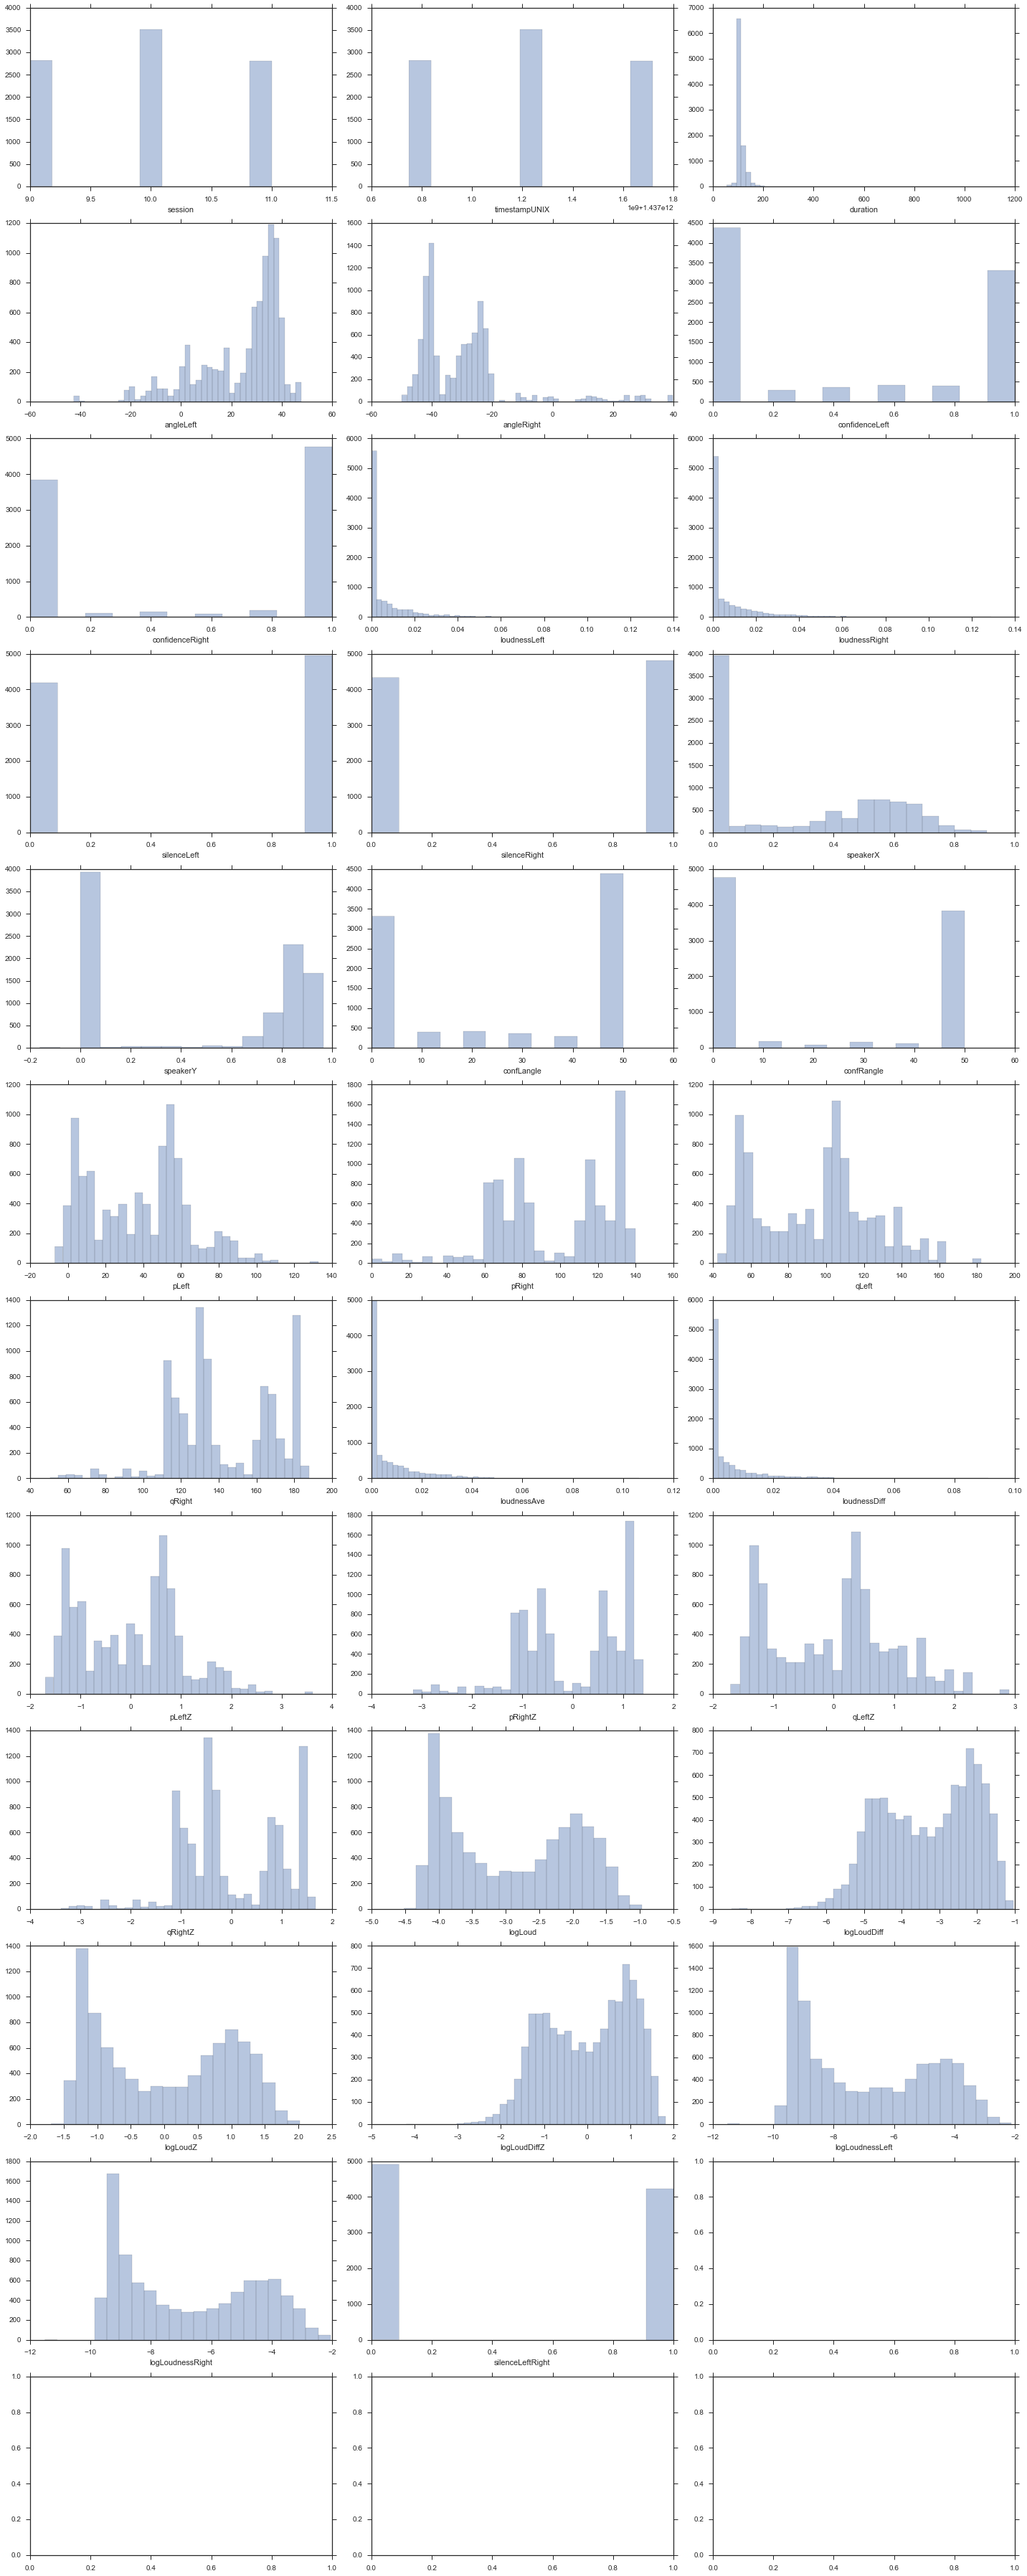

In [150]:
import matplotlib.pyplot as plt

first_row = train.iloc[0]
columns_to_plot = []
for column in train.columns:
    if type(first_row[column]) != type('hello'):
        columns_to_plot.append(column)

num_cols = 3
num_rows = int(len(columns_to_plot) / num_cols) + len(columns_to_plot) % num_cols
fig, axes = plt.subplots(num_rows, num_cols, squeeze=False)
for i, column in enumerate(columns_to_plot):
    # Tutorial at http://stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html#distribution-tutorial
    # Plot a histogram, showing a rug that shows all points in the distribution
    sns.distplot(train[column], ax=axes[i/num_cols][i%num_cols], kde=False)

fig.set_size_inches(20,50,forward=True)
fig.tight_layout()

#### Observations
* logLoud and logLoudZ have almost the same distribution, not surprising
* logLoudnessLeft and logLoudnessRight have same distribution as logLoud, probably can just use logLoud 

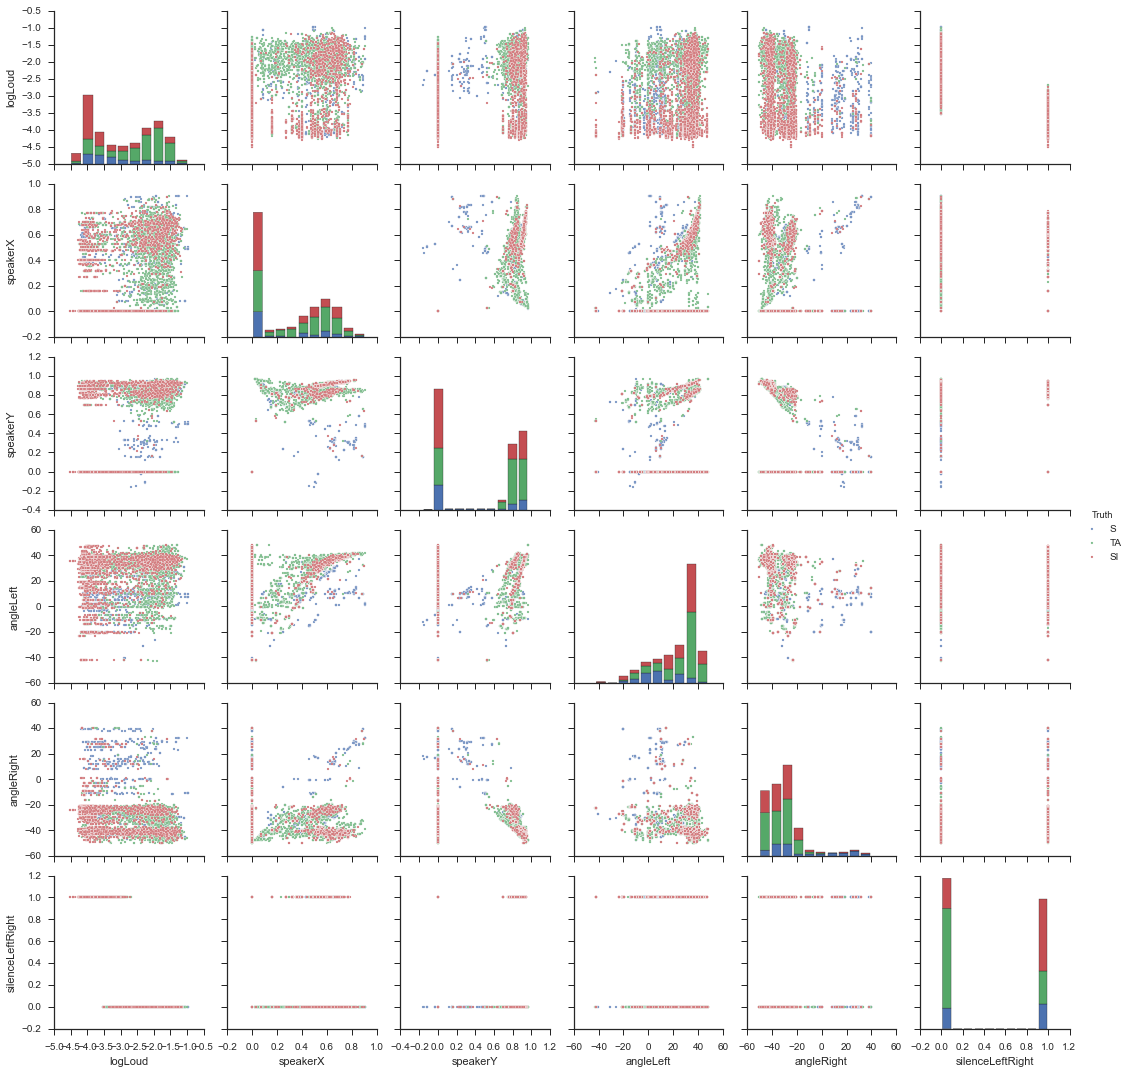

In [151]:
g = sns.pairplot(train,
                 markers='.', # use 'o' for a larger dot
                 vars=["logLoud", 
                       "speakerX", 
                       "speakerY",
                       "angleLeft",
                       "angleRight",
                       "silenceLeftRight"],
                 hue="Truth")

#### Observations
* speakerX seems to divide red (Silent) decently
* silenceLeft and silenctRight are less useless than I thought, seems like they separate silent data decently. Added silentLeftRight variable, which separates silent a little
* In speakerX vs. speakerY plot we can see some linear separation between blue (student), red(silent), green(ta). Blue tends to have low speakerY and high speakerX
* Silent data has more logLoud near low values (not surprising)
* Many of these separations look nonlinear. Quadratic or RBF kernel in SVM could work well

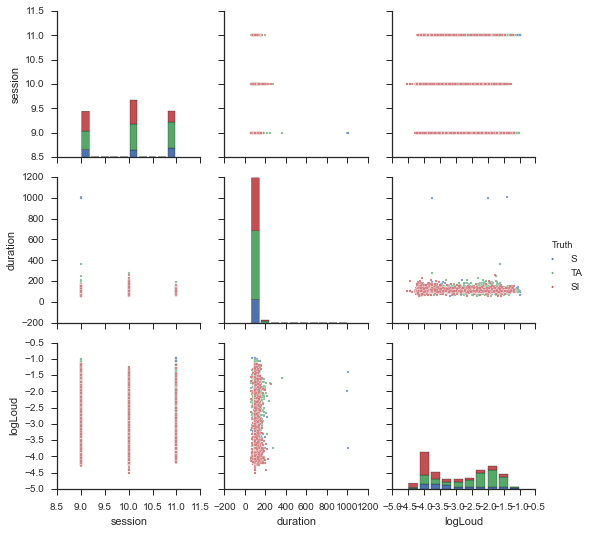

In [152]:
g = sns.pairplot(train,
                 markers='.', # use 'o' for a larger dot
                 vars=["session", 
                       "duration", 
                       "logLoud"],
                 hue="Truth")

#### Observations
* Some durations are long. Long duration means no silence.

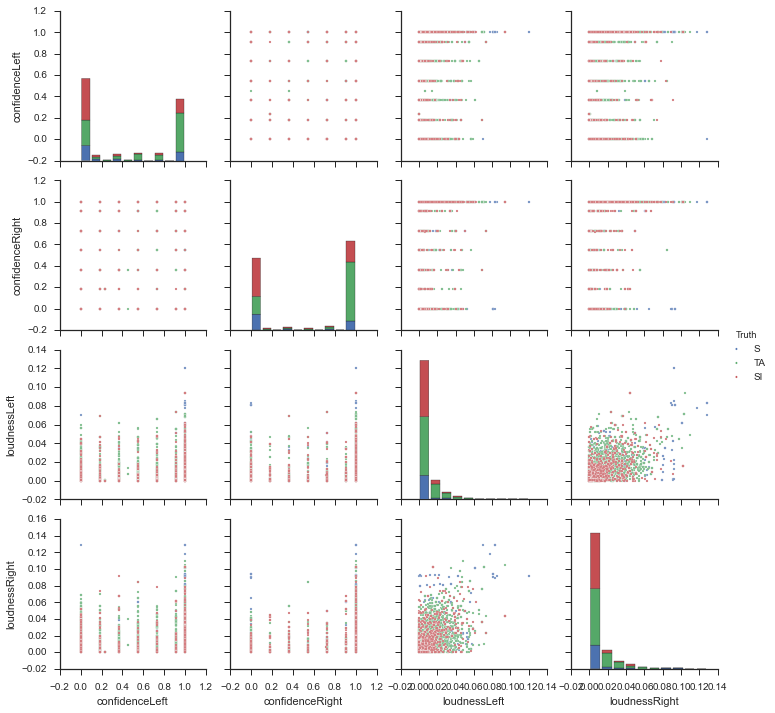

In [155]:
g = sns.pairplot(train,
                 markers='.', # use 'o' for a larger dot
                 vars=["confidenceLeft", 
                       "confidenceRight", 
                       "loudnessLeft",
                       "loudnessRight"],
                 hue="Truth")

#### Observations
* Confidence is very bimodal
* Not much correlation between loudness and confidence
* Most of data is pretty quiet, but when left is loud right tends to be loud as well

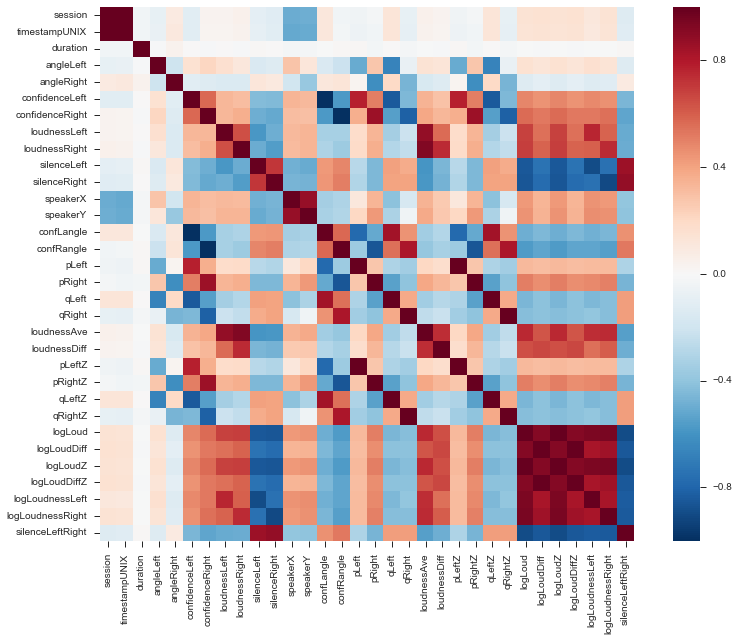

In [160]:
# Get correlations between variables
# source: http://stanford.edu/~mwaskom/software/seaborn/examples/network_correlations.html?highlight=heatmap
correlation_matrix = train.corr()
fig, axes = plt.subplots(1,1, figsize=(12,9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)
fig.tight_layout()
